In [28]:
import numpy as np
import networkx as nx
import pylab as plt
from scipy.stats import norm,uniform,binom,poisson
import random
from functools import reduce
from itertools import product

In [2]:
def float_range(stop, start=0, step=1):
    while start < stop:
        yield float(start)
        start += step 

def tuple_eq(tup1,tup2):
    return len(set(tup1).union(set(tup2))) == len(tup1) == len(tup2)
    
def tuple_rev(tup):
    return (tup[1],tup[0])

def tuple_int(tup1,tup2):
    return len(set(tup1).union(set(tup2))) < len(tup1) + len(tup2)

In [15]:
class Node:
    def __init__(self, coord:tuple[float], weight:float = 0) -> None:
        self.coord = coord # tuple of coordinates
        self.weight = weight # weight of node
        
    def __repr__(self) -> str:
        return f"Node({self.coord:.2f}, Weight{self.weight:.2f})"
    
    def __str__(self) -> str:
        return f"{self.coord:.2f}_{self.weight:.2f}"
    
    def __eq__(self, other):
        return self.coord == other.coord
    
    def __hash__(self):
        return hash(self.coord, self.weight)
    
    def __lt__(self, other):
        return self.weight < other.weight
    
    def __gt__(self, other):
        return self.weight > other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight

    def __iter__(self):
        return iter(self.coord)
    
    def __getitem__(self, key):
        return self.coord[key]
    
    def __abs__(self):
        return np.sqrt(reduce(lambda a,b : a+b ,map(lambda x: x ** 2, self.coord)))
    
    def __len__(self):
        return len(self.coord)
    
    def __contains__(self, item):
        return item in self.coord
    
    #############################################
    #############################################    
    #############################################
    # Properties
    #############################################
    #############################################
    #############################################
    
    @property
    def coord(self):
        return self._coord
    @coord.setter
    def coord(self, value) -> None:
        self._coord = value
        
    @property
    def weight(self):
        return self._weight
    @weight.setter
    def weight(self, value) -> None:
        self._weight = value
    
    #############################################
    #############################################    
    #############################################
    # Methods
    #############################################
    #############################################
    #############################################
    
    @classmethod
    def from_tuple(cls, tup) -> Self:
        return cls(tup[:-1], tup[-1])
    
    def distance(self, other):
        return np.sqrt(reduce(lambda a,b : a+b ,map(lambda x: (x[0] - x[1]) ** 2, zip(self.coord, other.coord))))
    
    def slope(self, other):
        if self[0] == other[0]:
            return np.inf
        return (other[1] - self[1]) / (other[0] - self[0])
    
    def intercept(self, other):
        if self[0] == other[0]:
            return np.nan
        return self[1] - self.slope(other) * self[0]
    
    def equation(self, other):
        if self[0] == other[0]:
            return f"x = {self[0]}"
        return f"y = {self.slope(other)}x + {self.intercept(other)}"
    
    def area(self, node1, node2):
        return abs((self[0] * (node1[1] - node2[1]) + node1[0] * (node2[1] - self[1]) + node2[0] * (self[1] - node1[1])) / 2)

In [26]:
class Edge:
    def __init__(self, nodes:tuple, dir:bool = False , weight:float = 1, key:int = 0):
        self.nodes = nodes # tuple of two nodes
        self.weight = weight # weight of the edge
        self.dir = dir # directed or undirected
        self.key = key # for multiedges
        
    def __repr__(self) -> str:
        if self.dir:
            return f"Edge({self.nodes[0]} -> {self.nodes[1]}, Weight{self.weight})" + f" with Key{self.key}"*(self.key != 0)
        return f"Edge({self.nodes[0]} <-> {self.nodes[1]}, Weight{self.weight})" + f" with Key{self.key}"*(self.key != 0)
    
    def __str__(self) -> str:
        if self.dir:
            return f"{self.nodes[0]} -> {self.nodes[1]}||{self.weight}" + f"||{self.key}"*(self.key != 0)
        return f"{self.nodes[0]} <-> {self.nodes[1]}||{self.weight}" + f"||{self.key}"*(self.key != 0)

    def __eq__(self, other):
        return self.nodes == other.nodes and self.dir == other.dir and self.key == other.key
    
    def __hash__(self):
        return hash(self.nodes, self.dir, self.weight, self.key)
    
    def __lt__(self, other):
        if self.nodes != other.nodes:
            raise ValueError("Edges are not comparable")
        return self.weight < other.weight and self.nodes == other.nodes and self.dir == other.dir
    
    def __gt__(self, other):
        if self.nodes != other.nodes:
            raise ValueError("Edges are not comparable")
        return self.weight > other.weight and self.nodes == other.nodes and self.dir == other.dir
    
    def __le__(self, other):
        if self.nodes != other.nodes:
            raise ValueError("Edges are not comparable")
        return self.weight <= other.weight and self.nodes == other.nodes and self.dir == other.dir
    
    def __ge__(self, other):
        if self.nodes != other.nodes:
            raise ValueError("Edges are not comparable")
        return self.weight >= other.weight and self.nodes == other.nodes and self.dir == other.dir
    
    def __iter__(self):
        return iter(self.nodes)
    
    def __getitem__(self, key):
        return self.nodes[key]
    
    def __abs__(self):
        return self.nodes[0].distance(self.nodes[1])
    
    def __neg__(self):
        if self.dir:
            return Edge(tuple_rev(self.nodes), self.dir, self.weight, self.key)
        else:
            raise ValueError("Undirected Edge")
        
    def __contains__(self, item) -> bool:
        return item in self.nodes
    
    #############################################
    #############################################    
    #############################################
    # Properties
    #############################################
    #############################################
    #############################################
    
    @property
    def nodes(self):
        return self._nodes
    @nodes.setter
    def nodes(self, value):
        self._nodes = value
    
    @property
    def weight(self):
        return self._weight
    @weight.setter
    def weight(self, value):
        self._weight = value
        
    @property
    def dir(self):
        return self._dir
    @dir.setter
    def dir(self, value):
        self._dir = value
        
    @property
    def key(self):
        return self._key
    @key.setter
    def key(self, value):
        self._key = value
        
    #############################################
    #############################################    
    #############################################
    # Methods
    #############################################
    #############################################
    #############################################
    
    @classmethod
    def new_edge(cls, node1, node2, dir:bool = False, weight:float = 1, key:int = 0):
        return cls((node1, node2), dir, weight, key)
    
    @classmethod
    def reverse_edge(cls, edge):
        return cls(tuple_rev(edge.nodes), edge.dir, edge.weight, edge.key)
    
    def other(self, node):
        if node not in self.nodes:
            raise ValueError("Node not in Edge")
        return self.nodes[1] if self.nodes[0] == node else self.nodes[0]
    
    def extremes(self):
        return self.nodes
    
    def is_loop(self):
        return self.nodes[0] == self.nodes[1]
    
    def is_multi(self, other):
        return tuple_eq(self.nodes,other.nodes) and self.dir == other.dir
    
    def is_parallel(self, other):
        if self.dir and other.dir:
            return self.nodes == other.nodes
        elif self.dir or other.dir:
            return False
        else:
            return tuple_eq(self.nodes,other.nodes)
        
    def is_anti_parallel(self, other):
        if self.dir and other.dir:
            return self.nodes == tuple_rev(other.nodes)
        elif self.dir or other.dir:
            return False
        else:
            return tuple_eq(self.nodes,other.nodes)
        
    def is_adjacent(self, other) -> bool:
        return tuple_int(self.nodes,other.nodes)

    def flip(self) -> Edge:
        return -self
    
    def raise_key(self):
        self.key += 1

In [33]:
class Network:
    def __init__(self, nodes = None, edges = None):
        self.nodes = nodes if nodes else []
        self.edges = edges if edges else []
        self.adjacency = { node : [] for node in self.nodes }
        for edge in self.edges:
            self.adjacency[edge[0]].append(edge[1])
            if not edge.dir:
                self.adjacency[edge[1]].append(edge[0])
    
    def __repr__(self,draw = False) -> str:
        if draw:
            self.draw()
        line_break = '=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-='
        return line_break + '\n' + \
                f"Network with {len(self.nodes)} Nodes and {len(self.edges)} Edges\n" + \
                line_break + '\n' + \
                'Nodes:\n' + '\n'.join([str(node) for node in self.nodes]) + '\n' + \
                line_break + '\n' + \
                'Edges:\n' + '\n'.join([str(edge) for edge in self.edges]) + '\n'
                
    def __str__(self) -> str:
        return self.__repr__(draw=False)
    
    def __iter__(self):
        return iter(self.nodes)
    
    def __getitem__(self, key):
        return self.nodes[key]
    
    def __len__(self):
        return len(self.nodes)
    
    def __contains__(self, item) -> bool:
        try:
            return item in self.nodes
        except:
            try:
                return item in self.edges
            except:
                False

    def __hash__(self) -> int:
        return hash(self.nodes, self.edges)
    
    def __eq__(self, other) -> bool:
        return self.nodes == other.nodes and self.edges == other.edges
    
    def __ne__(self, other) -> bool:
        return self.nodes != other.nodes or self.edges != other.edges
    
    def __add__(self, other):
        return Network(self.nodes + other.nodes, self.edges + other.edges)
    
    def __sub__(self, other):
        return Network([node for node in self.nodes if node not in other.nodes], [edge for edge in self.edges if edge not in other.edges])
    
    #############################################
    #############################################    
    #############################################
    # Properties
    #############################################
    #############################################
    #############################################
    
    @property
    def nodes(self):
        return self._nodes 
    @nodes.setter
    def nodes(self, value):
        self._nodes = value

    @property
    def edges(self):
        return self._edges
    @edges.setter
    def edges(self, value):
        self._edges = value
        
    #############################################
    #############################################    
    #############################################
    # Methods
    #############################################
    #############################################
    #############################################
    
    #############################################
    # Change/Compare Properties
    #############################################
    
        
    def adjacent_edges(self, node) -> list:
        return [edge for edge in self.edges if node in edge]
    
    def get_edges(self, node1, node2) -> Edge:
        return [edge for edge in self.edges if node1 in edge and node2 in edge] 

    def change_node_weight(self, node, weight):
        if node not in self.nodes:
            raise ValueError("Node not in Network")
        node.weight = weight
        
    def change_node_weights(self, weight_func):
        for node in self.nodes:
            node.weight = weight_func(node)
            
    def change_edge_weight(self, edge, weight):
        if edge not in self.edges:
            raise ValueError("Edge not in Network")
        edge.weight = weight
        
    def change_edge_weights(self, weight_func):
        for edge in self.edges:
            edge.weight = weight_func(edge)
    
    def func_node_compare(self, func, node, reduce = False):
        comparable = self.adjacency[node].copy()
        if reduce:
            return func(comparable)
        return map(func,comparable)
    
    def func_edge_compare(self, func, node1, node2, reduce = False):
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("Node not in Network")
        elif node2 not in self.adjacency[node1] and node1 not in self.adjacency[node2]:
            raise ValueError("Nodes are not adjacent")
        else:
            edges = self.get_edges(node1,node2)
            if reduce:
                return func(edges)
            else:
                return map(func,edges)
    
    #############################################
    # Add/Remove Nodes/Edges
    #############################################
     
    def add_node(self, node):
        if node not in self.nodes:
            self.nodes.append(node)
            self.adjacency[node] = []
        else:
            raise ValueError("Node already in Network")
        
    def add_nodes(self, nodes):
        for node in nodes:
            self.add_node(node)
    
    def add_edge(self, edge):
        if edge not in self.edges:
            self.edges.append(edge)
            self.adjacency[edge[0]].append(edge[1])
            if not edge.dir:
                self.adjacency[edge[1]].append(edge[0])
        else:
            self.add_edge(edge.raise_key())
    
    def add_edges(self, edges):
        for edge in edges:
            self.add_edge(edge)
            
    def remove_node(self, node):
        if node in self.nodes:
            self.nodes.remove(node)
            opposites = self.adjacency.pop(node)
            for opposite in opposites:
                self.adjacency[opposite].remove(node)
            for edge in self.edges:
                if node in edge:
                    self.edges.remove(edge)
        else:
            raise ValueError("Node not in Network")
        
    def remove_nodes(self, nodes):
        for node in nodes:
            self.remove_node(node)
            
    def remove_edge(self, edge):
        if edge in self.edges:
            self.edges.remove(edge)
            self.adjacency[edge[0]].remove(edge[1])
            if not edge.dir:
                self.adjacency[edge[1]].remove(edge[0])
        else:
            raise ValueError("Edge not in Network")
        
    def remove_edges(self, edges):
        for edge in edges:
            self.remove_edge(edge)
    
    #############################################
    # Components
    #############################################

    def complete_edge_subnetwork(self, nodes:list):
        edges = []
        for node1,node2 in product(nodes,nodes):
            edges.extend(self.get_edges(node1,node2))
        return Network(nodes,edges)
            
    def maximal_subnetwork(self, node):
        nodes = {node}
        traced = set()
        while nodes:
            node = nodes.pop()
            traced.add(node)
            for i in self.adjacency[node]:
                if i not in traced:
                    nodes.add(i)
        traced = list(traced)
        return self.complete_edge_subnetwork(traced)
    
    def maximal_subnetworks(self):
        traced = set()
        networks = []
        for node in self.nodes:
            if node not in traced:
                network = self.maximal_subnetwork(node)
                traced.update(network.nodes)
                networks.append(network)
        return networks

    def create_subnetwork(self, nodes, edges):
        return Network(nodes, edges)         
    
    def links_between(self, subnet1, subnet2):
        links = []
        for node1,node2 in product(subnet1.nodes,subnet2.nodes):
            links.extend(self.get_edges(node1,node2))
        return links
    
    def remove_all_edges(self):
        self.edges = []
        for node in self.nodes:
            self.adjacency[node] = []
        
    def max_key(self, node1, node2):
        return max(self.func_edge_compare(lambda x : x.weight , node1, node2, reduce = False))
        
    def create_edge(self, node1, node2, dir = False, weight = 1):
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("Node not in Network")
        elif not self.get_edges(node1,node2):
            self.add_edge(Edge(node1, node2, dir, weight))
        else:
            key = self.max_key(node1, node2)
            self.add_edge(Edge(node1, node2, dir = dir, weight = weight, key = key + 1))

    def complete_network(self):
        return Network(self.nodes, [Edge(node1, node2, dir = False, weight = 1) for node1, node2 in product(self.nodes, self.nodes)])

    def is_isolated(self, node) -> bool:
        return self.adjacency[node] == []
    
    def has_loop(self, node) -> bool:
        return node in self.adjacency[node]
    
    def is_connected(self) -> bool:
        return len(self.maximal_subnetworks()) == 1
    
    def is_complete(self) -> bool:
        return all(self.degree(node) == len(self.nodes) - 1 for node in self.nodes)
    
    def is_tree(self) -> bool:
        return self.is_connected() and not any(self.has_loop(node) for node in self.nodes)
    
    def degree(self, node) -> int:
        return len(self.adjacency[node])
    
    #############################################
    # Paths
    #############################################
    
    def is_path(self, nodes):
        return all(nodes[i+1] in self.adjacency[nodes[i]] for i in range(len(nodes)-1))
    
    def reconstruct_path(self, node1, node2, node_pool, consumed = set(),  path = None):
        if path is None:
            path = [node1]
        if node2 in self.adjacency[node1]:
            return path.extend([node2])
        else:
            for i in node_pool:
                if i not in consumed and i in self.adjacency[node1]:
                    path.append(i)
                    consumed.add(i)
                    return self.reconstruct_path(i, node2, node_pool, consumed, path)
    
    def get_path(self, node1, node2, proximity = None):
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("Node not in Network")
        elif node1 == node2:
            return [node1]
        elif node1 not in self.maximal_subnetwork(node2).nodes:
            return []
        if not proximity:
            proximity = {node1}
        proximity = proximity.union(self.adjacency[node1])
        if node2 in proximity:
            return self.reconstruct_path(node1, node2, proximity)
        else:
            for i in proximity:
                path = self.get_path(i, node2, proximity)
                if path:
                    return self.reconstruct_path(node1, i, proximity).extend(path)

    
    class Path:
        def __init__(self, network, path: list[Node]):
            self.network = network
            self.path = path
            
    

In [107]:
random.sample(range(1, 100), 10) #without replacement
random.choices(range(1, 100), k=10) #with replacement

[23, 94, 98, 51, 21, 6, 3, 55, 91, 32]

In [312]:
def vertex_generator(n , centred = False ,centred_around = (0,0), radius = 1 ,key = None ,random = False ,weighted = False):
    vertices = []
    if key == 'normal':
        sample_x = norm(loc = centred_around[0], scale = radius).rvs(n)
        sample_y = norm(loc = centred_around[1], scale = radius).rvs(n)
        vertices = [Vertex(sample_x[i], sample_y[i]) for i in range(n)]
    return vertices

def edge_generator(vertices, mu = 1 ,directed = False, weighted = False, key = None):
    edges = []
    unloop = lambda verts , vert : [v for v in verts if v != vert]
    nodes = len(vertices)
    vertices = vertices.copy()
    if key == 'uniform':
        for vertex in vertices:
            edge_number = max(random.randint(1, nodes-1) // (((nodes - 2) //(mu + 1))) , 0)
            edge_end = random.sample(unloop(vertices,vertex), edge_number)
            for i in edge_end:
                edges.append(Edge(vertex, i))
    elif key == 'poisson':
        while vertices:
            vertex = vertices.pop()
            edge_number = min(poisson.rvs(mu = mu, loc = 1,size = 1)[0], len(vertices))
            edge_end = random.sample(vertices, edge_number)
            print(vertex, edge_number,edge_end)
            for i in edge_end:
                edges.append(Edge(vertex, i))

    return edges

In [313]:
vertices = vertex_generator(10, key = 'normal', centred_around = (0,0), radius = 1)
edges = edge_generator(vertices, mu = 1,key = 'uniform')

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.Network.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°  Vertices  °°°°°°°°°°°°°°°°°°°°°°°°°°°°°

(-0.34, 1.69)
(-0.88, -1.76)
(0.02, 2.01)
(0.48, -0.52)
(0.71, 0.69)
(-1.17, -0.06)
(1.76, 0.35)
(-0.18, 1.09)
(0.37, 0.25)
(0.33, 1.20)


-->--->--->--->--->--->--->--->  Edges  <---<---<---<---<---<---<---<-

edge((-0.88, -1.76)--(-0.34, 1.69))
edge((0.02, 2.01)--(-0.34, 1.69))
edge((0.71, 0.69)--(-0.88, -1.76))
edge((-1.17, -0.06)--(-0.18, 1.09))
edge((-1.17, -0.06)--(0.37, 0.25))
edge((0.37, 0.25)--(-0.18, 1.09))
edge((0.37, 0.25)--(-1.17, -0.06))

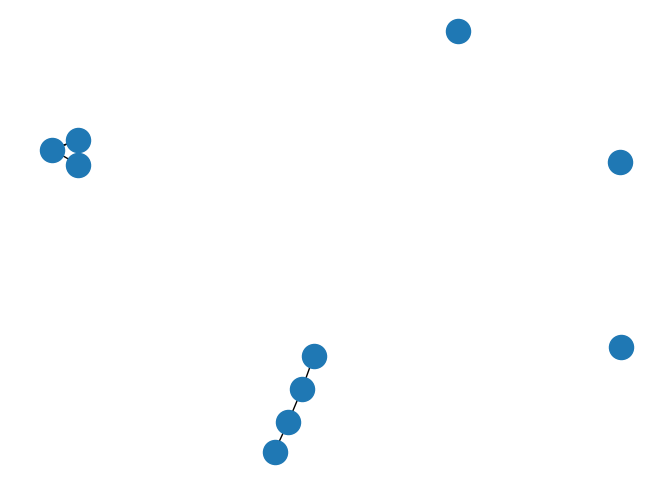

In [314]:
network = Network(vertices, edges, directed = False, e_weighted=False ,v_weighted=False)
x = network
x

In [315]:
for i in x.vertices:
    print(network.maximal_subnetwork(i))

Network

Vertices: ([vertex(-0.34, 1.69)])

Edges: ([])
Network

Vertices: ([vertex(-0.88, -1.76), vertex(-0.34, 1.69)])

Edges: ([edge((-0.88, -1.76)--(-0.34, 1.69))])
Network

Vertices: ([vertex(0.02, 2.01), vertex(-0.34, 1.69)])

Edges: ([edge((0.02, 2.01)--(-0.34, 1.69))])
Network

Vertices: ([vertex(0.48, -0.52)])

Edges: ([])
Network

Vertices: ([vertex(0.71, 0.69), vertex(-0.88, -1.76), vertex(-0.34, 1.69)])

Edges: ([edge((-0.88, -1.76)--(-0.34, 1.69)), edge((0.71, 0.69)--(-0.88, -1.76))])
Network

Vertices: ([vertex(-1.17, -0.06), vertex(-0.18, 1.09), vertex(0.37, 0.25)])

Edges: ([edge((-1.17, -0.06)--(-0.18, 1.09)), edge((-1.17, -0.06)--(0.37, 0.25)), edge((0.37, 0.25)--(-0.18, 1.09)), edge((0.37, 0.25)--(-1.17, -0.06))])
Network

Vertices: ([vertex(1.76, 0.35)])

Edges: ([])
Network

Vertices: ([vertex(-0.18, 1.09)])

Edges: ([])
Network

Vertices: ([vertex(-1.17, -0.06), vertex(-0.18, 1.09), vertex(0.37, 0.25)])

Edges: ([edge((-1.17, -0.06)--(-0.18, 1.09)), edge((-1.17, -

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.Network.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°  Vertices  °°°°°°°°°°°°°°°°°°°°°°°°°°°°°

(0.23, -0.40)
(0.35, 0.01)
(0.04, -0.13)
(0.23, 2.67)
(0.34, 1.30)
(0.22, -1.02)
(1.27, -2.14)
(0.96, 0.97)
(-0.10, -0.12)
(0.94, 0.60)


-->--->--->--->--->--->--->--->  Edges  <---<---<---<---<---<---<---<-

edge((0.94, 0.60)--(0.96, 0.97))
edge((0.94, 0.60)--(-0.10, -0.12))
edge((-0.10, -0.12)--(0.34, 1.30))
edge((0.96, 0.97)--(0.04, -0.13))
edge((0.96, 0.97)--(0.22, -1.02))
edge((0.96, 0.97)--(0.34, 1.30))
edge((1.27, -2.14)--(0.22, -1.02))
edge((1.27, -2.14)--(0.23, -0.40))
edge((1.27, -2.14)--(0.35, 0.01))
edge((0.22, -1.02)--(0.04, -0.13))
edge((0.22, -1.02)--(0.23, -0.40))
edge((0.34, 1.30)--(0.23, -0.40))
edge((0.23, 2.67)--(0.23, -0.40))
edge((0.04, -0.13)--(0.23, -0.40))
edge((0.35, 0.01)--(0.23, -0.40))

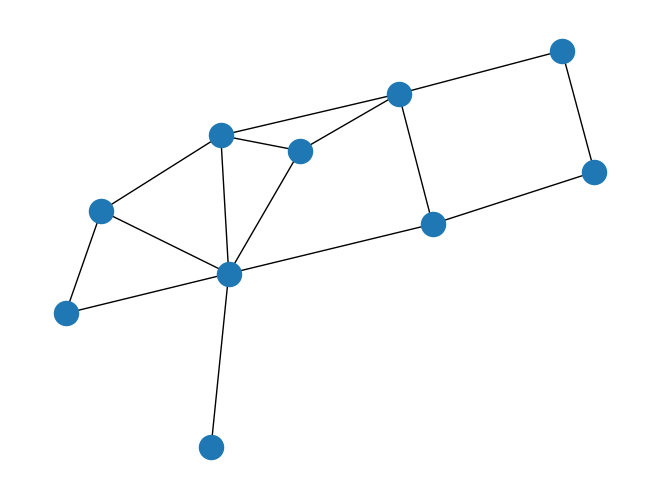

In [230]:
network

In [11]:
network = Network(vertices=list({Vertex(1,0) , Vertex(0,1), Vertex(1,1), Vertex(0,0)}), edges=list({Edge(Vertex(1,0), Vertex(0,1)), Edge(Vertex(1,0), Vertex(1,1)), Edge(Vertex(0,1), Vertex(1,1)), Edge(Vertex(0,1), Vertex(0,0)), Edge(Vertex(1,1), Vertex(0,0))}))

In [12]:
network.nontrivial_path(Vertex(1,0), Vertex(0,0))

(1.0, 0.0) -> (1.0, 1.0) -> (0.0, 0.0)

In [13]:
print(network.path_component(Vertex(1,0)))

{vertex(0.0, 1.0), vertex(1.0, 0.0), vertex(1.0, 1.0), vertex(0.0, 0.0)}


In [272]:
network2 = Network(vertices = list({Vertex(2,2), Vertex(3,2), Vertex(2,3), Vertex(3,3)}), edges = list({Edge(Vertex(2,2), Vertex(3,2)), Edge(Vertex(2,2), Vertex(2,3)), Edge(Vertex(3,2), Vertex(3,3)), Edge(Vertex(2,3), Vertex(3,3))}))

In [273]:
network2.vertices

[vertex(2.00, 3.00),
 vertex(3.00, 2.00),
 vertex(3.00, 3.00),
 vertex(2.00, 2.00)]

In [274]:
network2.edges

[edge((3.00, 2.00)--(3.00, 3.00)),
 edge((2.00, 2.00)--(3.00, 2.00)),
 edge((2.00, 3.00)--(3.00, 3.00)),
 edge((2.00, 2.00)--(2.00, 3.00))]

In [17]:
network3 = network + network2

In [18]:
network3.path_component(Vertex(1,0))

{vertex(0.0, 0.0), vertex(0.0, 1.0), vertex(1.0, 0.0), vertex(1.0, 1.0)}

In [ ]:
for i in network3.path_component(Vertex(1,0)):
    print(i)

[vertex(0.0, 1.0), vertex(1.0, 1.0)]
(0.0, 1.0)
(1.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)


In [ ]:
network3.path_component(Vertex(1,0))

[vertex(0.0, 1.0), vertex(1.0, 1.0)]


{vertex(0.0, 0.0), vertex(0.0, 1.0), vertex(1.0, 0.0), vertex(1.0, 1.0)}

In [ ]:
G = nx.Graph()
G.add_nodes_from(network4.vertices)
G.add_edges_from(list(map(lambda x: x.tuple, network4.edges)))

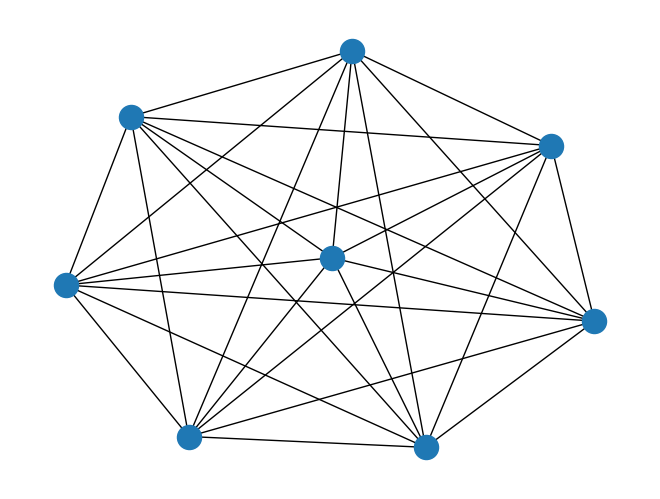

In [ ]:
nx.draw(G)

In [294]:
a = {1,2,3}
b = a.pop()
a, b

({2, 3}, 1)

In [300]:
network2 = Network(vertices = list({Vertex(2,2), Vertex(3,2), Vertex(2,3), Vertex(3,3)}), edges = list({Edge(Vertex(2,2), Vertex(3,2)), Edge(Vertex(2,2), Vertex(2,3)), Edge(Vertex(3,2), Vertex(3,3)), Edge(Vertex(2,3), Vertex(3,3))}))
Edge(Vertex(2,2), Vertex(1,2)) in network2

False

In [301]:
network2.adjacent_vertices(Vertex(2,2))

[vertex(3.00, 2.00), vertex(2.00, 3.00)]

In [302]:
nt = network2.remove_all_edges()

In [303]:
network2.add_edge(Edge(Vertex(2,2), Vertex(1,2)))

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.Network.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°  Vertices  °°°°°°°°°°°°°°°°°°°°°°°°°°°°°

(1.00, 2.00)
(2.00, 3.00)
(3.00, 3.00)
(2.00, 2.00)
(3.00, 2.00)


-->--->--->--->--->--->--->--->  Edges  <---<---<---<---<---<---<---<-

edge((3.00, 2.00)--(3.00, 3.00))
edge((2.00, 2.00)--(3.00, 2.00))
edge((2.00, 3.00)--(3.00, 3.00))
edge((2.00, 2.00)--(2.00, 3.00))
edge((2.00, 2.00)--(1.00, 2.00))

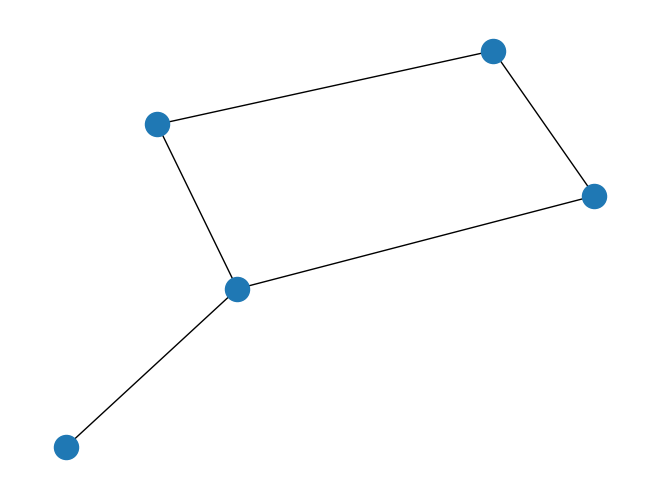

In [304]:
network2.maximal_subnetwork(Vertex(2,2))

In [320]:
x = {Edge(Vertex(2,2), Vertex(1,2)), Edge(Vertex(1,2), Vertex(2,2))}

In [321]:
x

{edge((1.00, 2.00)--(2.00, 2.00)), edge((2.00, 2.00)--(1.00, 2.00))}